
# HDA Flowsheet Costing


## Note

This tutorial will demonstrate adding capital and operating costs to the two HDA examples, the basic [HDA with Flash](../../Tutorials/Basics/HDA_flowsheet_solution.ipynb) and a comparison with the [HDA with Distillation](HDA_flowsheet_with_distillation_solution.ipynb).


## Learning outcomes


- Import external pre-built steady-state flowsheets using the IDAES unit model library
- Define and add costing blocks using the IDAES Process Costing Framework
- Fomulate and solve a process economics optimization problem
    - Defining an objective function
    - Setting variable bounds
    - Adding additional constraints 


## Problem Statement

Hydrodealkylation is a chemical reaction that often involves reacting
an aromatic hydrocarbon in the presence of hydrogen gas to form a
simpler aromatic hydrocarbon devoid of functional groups. In this
example, toluene will be reacted with hydrogen gas at high temperatures
 to form benzene via the following reaction:

**C<sub>6</sub>H<sub>5</sub>CH<sub>3</sub> + H<sub>2</sub> → C<sub>6</sub>H<sub>6</sub> + CH<sub>4</sub>**


This reaction is often accompanied by an equilibrium side reaction
which forms diphenyl, which we will neglect for this example.

This example is based on the 1967 AIChE Student Contest problem as
present by Douglas, J.M., Chemical  Design of Chemical Processes, 1988,
McGraw-Hill.

Users may refer to the prior examples linked at the top of this notebook for detailed process descriptions of the two HDA configurations. As before, the properties required for this module are defined in

- `hda_ideal_VLE.py`
- `idaes.models.properties.activity_coeff_models.BTX_activity_coeff_VLE`
- `hda_reaction.py`

Additionally, we will be importing externally-defined flowsheets for the two HDA configurations from

- `hda_flowsheets_for_costing_notebook.py`

## Import and run HDA Flowsheets
First, we will generate solved flowsheets for each HDA model. The external scripts build and set inputs for the flowsheets, initialize unit models and streams, and solve the flowsheets before returning the model objects. Note that the HDA flowsheets contain all unit models and stream connections, and no costing equations.

The flowsheet utilizes the Wegstein method to iteratively solve circular dependencies such as recycle streams, and is intended to approach a feasible solution. As such, the calls below will fail to converge after 3 iterations and pass to IPOPT to obtain an optimal solution as expected:

In [1]:
# Source file for prebuilt flowsheets
from hda_flowsheets_for_costing_notebook import hda_with_flash
# Build hda model with second flash unit and return model object
m = hda_with_flash(tee=True)

Building flowsheet...

Setting inputs...

Initializing flowsheet...

Limiting Wegstein tear to 3 iterations to obtain initial solution, if not converged IPOPT will pick up and continue.

fs.s03
fs.H101
fs.R101
fs.F101
fs.S101
fs.C101
fs.M101
2022-09-23 09:00:50 [INFO] idaes.init.fs.H101.control_volume: Initialization Complete
2022-09-23 09:00:50 [INFO] idaes.init.fs.H101: Initialization Complete: optimal - Optimal Solution Found
2022-09-23 09:00:51 [INFO] idaes.init.fs.R101.control_volume: Initialization Complete
2022-09-23 09:00:51 [INFO] idaes.init.fs.R101: Initialization Complete: optimal - Optimal Solution Found
2022-09-23 09:00:51 [INFO] idaes.init.fs.F101.control_volume: Initialization Complete
2022-09-23 09:00:52 [INFO] idaes.init.fs.F101: Initialization Complete: optimal - Optimal Solution Found
2022-09-23 09:00:52 [INFO] idaes.init.fs.S101.purge_state: Initialization Complete
2022-09-23 09:00:52 [INFO] idaes.init.fs.S101.recycle_state: Initialization Complete
2022-09-23 09:00:

Complete.



## IDAES Process Costing Framework
IDAES provides a library of capital costing correlations based on those in the following source:

*Process and Product Design Principles: Synthesis, Analysis, and Evaluation*. Seider, Seader, Lewin, Windagdo, 3rd Ed. John Wiley and Sons Chapter 22. Cost Accounting and Capital Cost Estimation 22.2 Cost Indexes and Capital Investment.

Currently, IDAES supports calculation of capital costing for a wide array of unit operations, vesseel sizing and material properties, and specific unit options such as column tray types and heat exchanger configurations. Users may find further information on specific costing methods and options in the IDAES Process Costing Framework documentation (link pending).


## Add Operating Cost Equations
Before adding capital costing blocks, we will add operating cost equations taken from the basic [HDA with Flash](../../Tutorials/Basics/HDA_flowsheet_solution.ipynb) and the [HDA with Distillation](HDA_flowsheet_with_distillation_solution.ipynb) examples. The examples assume constant cooling and heating coefficients over an annual cost basis. The IDAES Generic Costing Framework does not currently support variable cost calculations.

In [2]:
# Required imports
from pyomo.environ import Expression

# Operating costs for HDA with second flash (model m)
m.fs.cooling_cost = Expression(expr=0.212e-7 * (-m.fs.F101.heat_duty[0]) +
                                   0.212e-7 * (-m.fs.R101.heat_duty[0]))
m.fs.heating_cost = Expression(expr=2.2e-7 * m.fs.H101.heat_duty[0] +
                                   1.9e-7 * m.fs.F102.heat_duty[0])
m.fs.operating_cost = Expression(expr=(3600 * 24 * 365 *
                                           (m.fs.heating_cost +
                                            m.fs.cooling_cost)))

## Add Capital Costing
Below, we will add add capital costing blocks to the imported flowsheets and evaluate the economic impact of replacing the second Flash with a Distillation column. First, let's import and define the main flowsheet costing block:

In [3]:
# Import costing methods - classes, heaters, vessels, compressors, columns
from idaes.models.costing.SSLW import (
    SSLWCosting,
    SSLWCostingData,
)
from idaes.core import UnitModelCostingBlock

# Costing block
m.fs.costing = SSLWCosting()

Next, we will build the relevant costing blocks for the equipment we wish to cost. Note how the costing block, methods and flags are passed as arguments in the costing block call itself. Each unit model will have a single costing block, but each flowsheet model (m and n) will also have a single costing block for flowsheet-level properties.

Users should note that IDAES costing methods support a wide array of heating sources (e.g. fired, steam boiler, hot water) and do not support direct capital costing of coolers. If users wish to cost Heater units acting as coolers, it is necessary to cost a "dummy" [0D shell and tube exchanger](https://idaes-pse.readthedocs.io/en/stable/reference_guides/model_libraries/generic/unit_models/heat_exchanger.html) with appropriate aliased hot stream properties and proper cooling water properties. This is not demonstrated here, as the HDA examples take advantage of Flash and Condenser operations to recover liquid product.

Capital costing is independent of unit model connections, and building cost equations may be done piecewise in this fashion. Default options are passed explicitly to demonstrate proper syntax and usage. Now that all required properties are defined, let's cost our models connecting costing blocks, methods and unit models in each flowsheet.

### Flexibility of Costing Block Definitions
IDAES supports many ways to define batches of costing blocks, and several are shown in the example. Users may employ whichever method fits their modeling needs for explicit or concise code. In the code below, note how the unit model itself is never passed to the costing method; when the full model is executed, the costing block will automatically connect its parent block with child equation blocks.

`Compressor` unit models with isothermal or adiabatic thermodynamics are too simple to cost and are therefore excluded from the economic analysis.

Let's define costing for the heater unit:

In [4]:
from idaes.models.costing.SSLW import (
    HeaterMaterial,
    HeaterSource,
)
# Costing for heater - m.fs.H101
m.fs.H101.costing = UnitModelCostingBlock(
    flowsheet_costing_block=m.fs.costing,
    costing_method=SSLWCostingData.cost_fired_heater,
    costing_method_arguments={
            "material_type": HeaterMaterial.CarbonSteel,
            "heat_source": HeaterSource.Fuel,
        }
)

The costing module provides a `unit_mapping` dictionary linking generic unit model classes with recommended costing methods. In this example, StoichiometricReactor and Flash vessels utilize different vessel costing methods with similar arguments. The diameter and length attributes need to exist in order to cost vessel sizing and material requirements, and we add them if they don't exist already. The `unit_mapping` method provides an opportunity to automatically select the correct vessel orientation (vertical or horizontal) based on the unit type; passing a `StoichiometricReactor` or `PFR` class object will call the `cost_horizontal_vessel` method, while passing a `Flash` or `CSTR` class object will call the `cost_vertical_vessel` method.

All vessels are assigned costing succintly via a loop below - users may define each block individually if desired:

In [5]:
from idaes.models.costing.SSLW import (
    VesselMaterial,
    TrayType,
    TrayMaterial,
)

from idaes.core.util.constants import Constants
from pyomo.environ import Var, Constraint, units as pyunits, Param, value
from idaes.models.unit_models import StoichiometricReactor, Flash
# Map unit models to unit classes
# Will pass to unit_mapping which calls costing methods based on unit class
unit_class_mapping = {m.fs.R101: StoichiometricReactor,
                      m.fs.F101: Flash,
                      m.fs.F102: Flash,}

# Costing for vessels - m.fs.R101, m.fs.F101, m.fs.F102

# Loop over units
for unit in [m.fs.R101, m.fs.F101, m.fs.F102]:
    # Get correct unit class for unit model
    unit_class = unit_class_mapping[unit]
    
    # Add dimension variables and constraint if they don't exist
    if not hasattr(unit, "diameter"):
        unit.diameter = Var(initialize=1, units=pyunits.m)
    if not hasattr(unit, "length"):
        unit.length = Var(initialize=1, units=pyunits.m)
    if hasattr(unit, "volume"):  # if volume exists, set diameter from volume
        unit.volume_eq = Constraint(expr=unit.volume[0] == unit.length * unit.diameter**2 * 0.25 * Constants.pi)
    else:  # fix diameter directly
        unit.diameter.fix(0.2214 * pyunits.m)
    # Either way, fix L/D to calculate L from D
    unit.L_over_D = Constraint(expr=unit.length == 3 * unit.diameter)
        
    # Define vessel costing
    unit.costing = UnitModelCostingBlock(
        flowsheet_costing_block=unit.parent_block().costing,  # e.g. m.fs.R101.costing
        costing_method=SSLWCostingData.unit_mapping[unit_class],  # e.g. cost_vertical_vessel()
        costing_method_arguments={
            "material_type": VesselMaterial.CarbonSteel,
            "shell_thickness": 1.25 * pyunits.inch,

            }
    )

## Solve Flowsheet Costing Blocks
Now, we may solve the full flowsheet for all costing blocks:

In [6]:
# Eefine solver
from idaes.core.solvers import get_solver
solver = get_solver()

# Check that the degrees of freedom is zero
from idaes.core.util.model_statistics import degrees_of_freedom
assert degrees_of_freedom(m) == 0

In [7]:
# Check physical units consistency, solve and check solver status
from pyomo.environ import TerminationCondition
from pyomo.util.check_units import assert_units_consistent

assert_units_consistent(m)
results = solver.solve(m, tee=True, symbolic_solver_labels=True)
assert results.solver.termination_condition == TerminationCondition.optimal

Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale

For comparison, we will call and build the HDA flowsheet replacing the second `Flash` with a `TrayColumn` distillation unit model. The flowsheet costing occurs in the external script `hda_flowsheets_for_costing_notebook.py` and is not shown here:

In [8]:
from pyomo.common.log import LoggingIntercept
import logging
from io import StringIO

stream = StringIO()
with LoggingIntercept(stream, "idaes", logging.WARNING):
    # Source file for prebuilt flowsheets
    from hda_flowsheets_for_costing_notebook import hda_with_distillation
    # Build hda model with distillation column and return model object
    n = hda_with_distillation(tee=False)

Building flowsheet...

Setting inputs...

Initializing flowsheet...

Limiting Wegstein tear to 3 iterations to obtain initial solution, if not converged IPOPT will pick up and continue.

Solving flowsheet...

Adding distillation column and resolving flowsheet...

Complete.



## Results Comparison and Visualization
For the two flowsheets above, let's sum the total operating and capital costs of each scenario. We will display overall process economics results and compare the two flowsheets:

In [9]:
# Imports and data gathering
from matplotlib import pyplot as plt
plt.style.use('dark_background')  # if using browser in dark mode, uncomment this line
import numpy as np
import pandas as pd

# Automatically get units that we costed - this will exclude C101 for both flowsheets

two_flash_unitlist = [getattr(m.fs, unit) for unit in dir(m.fs)
                      if hasattr(getattr(m.fs, unit), "costing")]
distillation_unitlist = [getattr(n.fs, unit) for unit in dir(n.fs)
                       if hasattr(getattr(n.fs, unit), "costing")]

Costs in $1000:


Equipment,fs.H101,fs.R101,fs.F101,fs.F102,fs.D101,fs.H102
Distillation,13.283334,13.552294,7.781332,0.000000,7.60743,3.32944
Two Flash,13.283334,10.755878,7.781332,7.781332,0.00000,0.00000


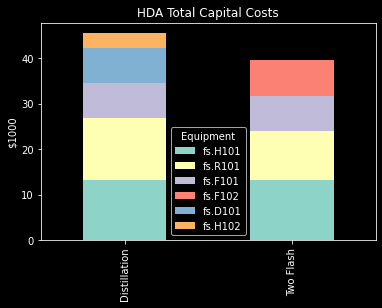

In [10]:
# Compare equipment purchase costs (actual capital costs)

two_flash_capcost = {unit.name: value(unit.costing.capital_cost/1e3)
                     for unit in two_flash_unitlist}
distillation_capcost = {unit.name: value(unit.costing.capital_cost/1e3)
                      for unit in distillation_unitlist}

two_flash_capdf = pd.DataFrame(list(two_flash_capcost.items()),
                            columns=['Equipment','Two Flash']).set_index('Equipment')
distillation_capdf = pd.DataFrame(list(distillation_capcost.items()),
                             columns=['Equipment','Distillation']).set_index('Equipment')

# Add dataframes, merge same indices, replace NaNs with 0s, and transpose
capcosts = two_flash_capdf.add(distillation_capdf, fill_value=0).fillna(0).transpose()

# Sort according to an easier order to view
capcosts = capcosts[['fs.H101', 'fs.R101', 'fs.F101', 'fs.F102', 'fs.D101', 'fs.H102']]

print('Costs in $1000:')
display(capcosts)  # view dataframe before plotting

capplot = capcosts.plot(kind='bar', stacked=True, title='HDA Total Capital Costs', ylabel='$1000')

Costs in $1000:


Utilities,cooling,heating
Distillation,60.193668,367.399338
Two Flash,47.028803,372.093536


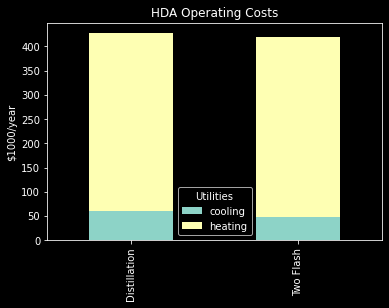

In [11]:
# Compare operating costs (per year)

two_flash_opcost = {'cooling': value(3600 * 24 * 365 * m.fs.cooling_cost/1e3),
                    'heating': value(3600 * 24 * 365 * m.fs.heating_cost/1e3)}
distillation_opcost = {'cooling': value(3600 * 24 * 365 * n.fs.cooling_cost/1e3),
                     'heating': value(3600 * 24 * 365 * n.fs.heating_cost/1e3)}

two_flash_opdf = pd.DataFrame(list(two_flash_opcost.items()),
                            columns=['Utilities','Two Flash']).set_index('Utilities')
distillation_opdf = pd.DataFrame(list(distillation_opcost.items()),
                             columns=['Utilities','Distillation']).set_index('Utilities')

# Add dataframes, merge same indices, replace NaNs with 0s, and transpose
opcosts = two_flash_opdf.add(distillation_opdf, fill_value=0).fillna(0).transpose()

print('Costs in $1000:')
display(opcosts)  # view dataframe before plotting

opplot = opcosts.plot(kind='bar', stacked=True, title='HDA Operating Costs', ylabel='$1000/year')

Costs in $1000:


Costs,capital,operating
Distillation,45.553829,427.593007
Two Flash,39.601876,419.122339


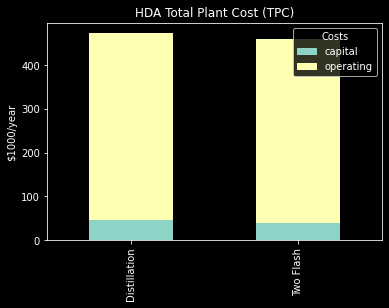

In [12]:
# Compare total costs (capital costs and operating costs)

two_flash_totcost = {'capital': sum(two_flash_capcost[idx] for idx in two_flash_capcost),
                    'operating': value(m.fs.operating_cost)/1e3}
distillation_totcost = {'capital': sum(distillation_capcost[idx] for idx in distillation_capcost),
                     'operating': value(n.fs.operating_cost)/1e3}

two_flash_totdf = pd.DataFrame(list(two_flash_totcost.items()),
                            columns=['Costs','Two Flash']).set_index('Costs')
distillation_totdf = pd.DataFrame(list(distillation_totcost.items()),
                             columns=['Costs','Distillation']).set_index('Costs')

# Add dataframes, merge same indices, replace NaNs with 0s, and transpose
totcosts = two_flash_totdf.add(distillation_totdf, fill_value=0).fillna(0).transpose()

print('Costs in $1000:')
display(totcosts)  # view dataframe before plotting

totplot = totcosts.plot(kind='bar', stacked=True, title='HDA Total Plant Cost (TPC)', ylabel='$1000/year')

Finally, let's compare the total costs on a production basis. This will account for the greater efficiency provided by the distillation column relative to the less-expensive second flash unit:

In [13]:
two_flash_cost = value(1e3*sum(two_flash_totcost[idx] for idx in two_flash_totcost))
two_flash_prod = value(m.fs.F102.vap_outlet.flow_mol_phase_comp[0, "Vap", "benzene"] * 365 * 24 * 3600)
distillation_cost = value(1e3*sum(distillation_totcost[idx] for idx in distillation_totcost))
distillation_prod = value(n.fs.D101.condenser.distillate.flow_mol[0] * 365 * 24 * 3600)

print(f"Two flash case over one year: ${two_flash_cost/1e3:0.0f}K / {two_flash_prod/1e3:0.0f} kmol benzene = ${two_flash_cost/(two_flash_prod/1e3):0.2f} per kmol benzene produced")
print(f"Distillation case over one year: ${distillation_cost/1e3:0.0f}K / {distillation_prod/1e3:0.0f} kmol benzene = ${distillation_cost/(distillation_prod/1e3):0.2f} per kmol benzene produced")

Two flash case over one year: $459K / 4477 kmol benzene = $102.45 per kmol benzene produced
Distillation case over one year: $473K / 5110 kmol benzene = $92.60 per kmol benzene produced


# Summary
In this example, IDAES Process Costing Framework methods were applied to two HDA flowsheets for capital cost estimation. The costing blocks calls showcased multiple methods to define unit costing, demonstrating the flexibility and best practice of the costing framework. In the basic examples, the two-flash HDA did not include costing and the distillation HDA estimated a reactor capital cost comprising 3.3% of the total plant cost (TPC). With more rigorous costing, IDAES obtained total capital costs of 8.5% TPC (two flash HDA) and 9.6% (distillation HDA) and better modeled the impact of equipment cost on process economics. As printed above, the IDAES Process Costing Framework confirmed that replacing the second flash drum with a distillation column results in increased equipment costs, increased production and decreased cost per unit product.